In [1]:
import pandas as pd
from SyntheticControlMethods import Synth
import random
import numpy as np
from sklearn.neighbors import KDTree
import cvxpy as cvx
from scipy.optimize import minimize, differential_evolution
import pickle

In [2]:
treated_unit= '81959733'
treated_period = 2014
id_var = 'pidp'
time_var = 'year'
outcome_var = 'ind_inc_deflated'

In [3]:
df = pd.read_csv('./test_data.csv', index_col=0)
df['pidp'] = df['pidp'].astype(str)
df.dtypes

year                float64
pidp                 object
asian               float64
black               float64
dvage               float64
ind_inc_deflated    float64
low                 float64
mastat_recoded      float64
middle              float64
mixed               float64
other               float64
dtype: object

In [4]:
t_u = df[df.pidp==treated_unit].copy()

In [5]:
c_u = df[df.pidp!=treated_unit].copy()

In [6]:
selection = random.sample(c_u.pidp.unique().tolist(), 100)

In [7]:
sample = df[df.pidp.isin(selection)]
data = pd.concat([sample,t_u], axis=0)

In [51]:
sc = Synth(dataset=data, outcome_var=outcome_var, id_var=id_var, time_var=time_var, treatment_period=treated_period, treated_unit=treated_unit)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35314D+06    |proj g|=  8.88889D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     14      7     0     4   0.000D+00   4.880D+06
  F =   4880002.1749827657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      3     61     14     0     6   1.000D+00   1.632D+06
  F =   1631899.5196072005     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75246D+06    |proj g|=  9.99925D-01

At iterate    3    f=  8.78512D+05    |proj g|=  9.95910D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

In [54]:
sc.original_data.synth_outcome

array([[ 936.10681198, 1133.67749515,  751.9184908 , 1128.97734418,
         973.4547028 , 1419.62064939,  955.28609833, 1138.53703399,
        1135.0154623 ]])

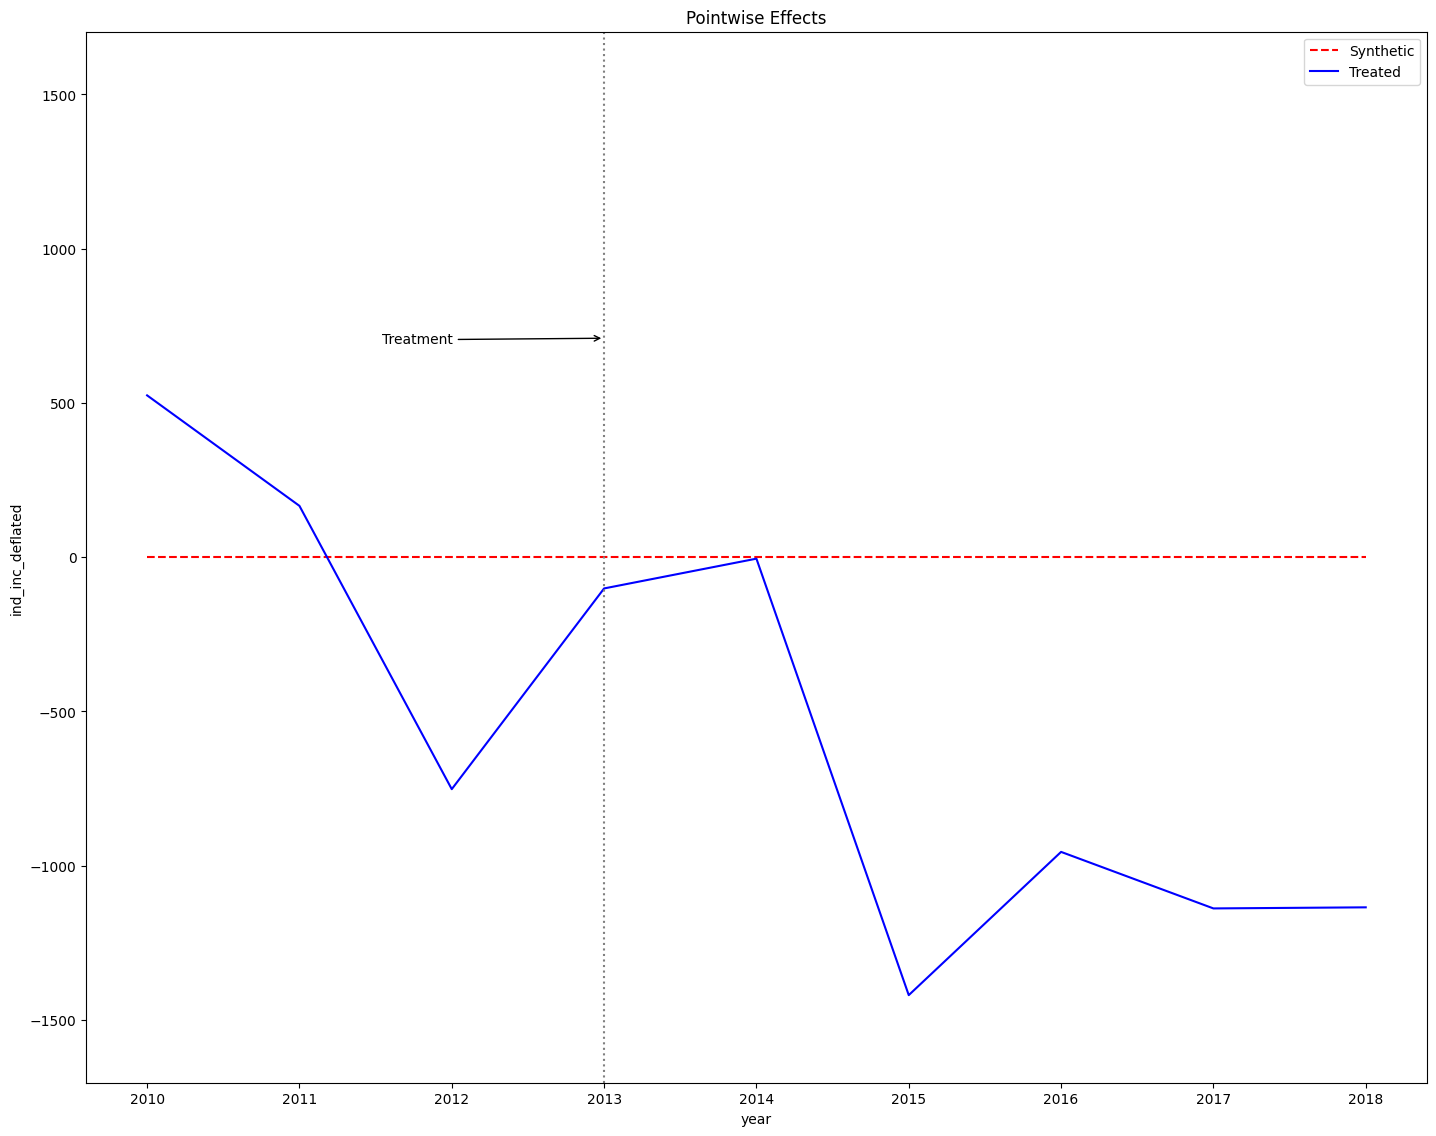

In [9]:
sc.plot(["pointwise"], treated_label="Treated", 
            synth_label="Synthetic", treatment_label="Treatment")

In [16]:
def get_control_matrices(data_object):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    c_out_all = np.array([x for x in data.iloc[:,1:].loc[[target_var]].values])
    c_out = np.array([x for x in data.iloc[:,1:].loc[[target_var]].loc[(slice(None), slice(None, t_time-1)), :].values])
    l_means = data.iloc[:,1:].sort_index().loc[(slice(None), slice(None, t_time-1)), :].groupby(level='var').mean()
    c_cov_mean = np.array([x for x in l_means.values])
    return c_out_all, c_out, c_cov_mean

In [17]:
def get_control_matrices_b(data_object, k_n):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
    sample_weights.index = sample_weights.index - t_time
    data = data.sort_index(ascending=True).copy()
    df_T0 = data.loc[pd.IndexSlice[:, :-1], :]
    if ncol < k_n:
        k_n = ncol
    try:
        kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    except ValueError:
        return None
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, :]
    select_data = data.iloc[:, idx]
    select_df_T0 = df_T0.iloc[:, idx]
    c_out_all = np.array([x for x in select_data.iloc[:,1:].loc[[target_var]].values])
    c_out = np.array([x for x in select_df_T0.iloc[:,1:].loc[[target_var]].values])
    l_means = select_df_T0.iloc[:,1:].sort_index().groupby(level='var').mean()
    c_cov_mean = np.array([x for x in l_means.values])
    return c_out_all, c_out, c_cov_mean

In [18]:
def get_treat_matrices(data_object):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    t_out_all = np.array([[x] for x in data.iloc[:,0][target_var].values])
    t_out = np.array([[x] for x in data.iloc[:,0][target_var][:t_time-1].values])
    l_means = data.iloc[:,:1].sort_index().loc[(slice(None), slice(None, t_time-1)), :].groupby(level='var').mean().mean(axis=1)
    t_cov_mean = np.array([[x] for x in l_means.values])
    return t_out_all, t_out, t_cov_mean

In [19]:
def rescale_covariate_variance(treated_covariates, control_covariates, n_covariates):
    '''Rescale covariates to be unit variance'''
    big_dataframe = np.concatenate((treated_covariates, control_covariates), axis=1)
    big_dataframe /= np.apply_along_axis(np.std, 0, big_dataframe)
    treated_covariates = big_dataframe[:,0].reshape(n_covariates, 1)
    control_covariates = big_dataframe[:,1:]
    return treated_covariates, control_covariates

In [20]:
def get_pairwise_difference_matrix(treated_covariates, control_covariates):
    '''
    Computes matrix of same shape as control_covariates, but with unit-wise difference from treated unit
    Used in optimization objective for both SC and DSC
    '''
    return treated_covariates - control_covariates

In [21]:
def total_loss(v_0,
               treated_outcome,
               treated_covariates,
               control_outcome,
               control_covariates,
               pairwise_difference,
               pen):
    '''
    Solves for w*(v) that minimizes loss function 1 given v,
    Returns loss from loss function 2 with w=w*(v)

    placebo: bool
        indicates whether the optimization is ran for finding the real synthetic control
        or as part of a placebo-style validity test. If True, only placebo class attributes are affected.
    '''
    min_loss = float("inf")

    n_controls = control_outcome.shape[1]

    V = np.diag(v_0)
    pen_coef = pen
        
        # Construct the problem - constrain weights to be non-negative
    w = cvx.Variable((n_controls, 1), nonneg=True)
        
        #Define the objective

        #PROBLEM: treated_synth_difference = cvx.sum(V @ cvx.square(treated_covariates.T - control_covariates @ w)) runs better for normal sc,
        #but it doesnt work at all for in-time placebos, this probably means I am messing up the dimensionality somewhere in the processing
        #This is a work-around that works, but it ain't pretty

    treated_synth_difference = cvx.sum(V @ cvx.square(treated_covariates.T - control_covariates @ w))
        
    pairwise_difference = cvx.sum(V @ (cvx.square(pairwise_difference) @ w))
    objective = cvx.Minimize(treated_synth_difference + pen_coef*pairwise_difference)

        #Add constraint sum of weights must equal one
    constraints = [cvx.sum(w) == 1]
        
        #Solve problem
    problem = cvx.Problem(objective, constraints)
        
    try: #Try solving using current value of V, if it doesn't work return infinite loss
        result = problem.solve(verbose=False)
        loss = (treated_outcome - control_outcome @ w.value).T @ (treated_outcome - control_outcome @ w.value)
    except:
        return float(np.inf)
       
    #If loss is smaller than previous minimum, update loss, w and v
    if loss < min_loss:
        min_loss = loss
        w = w.value
        v = np.diagonal(V) / np.sum(np.diagonal(V)) #Make sure its normailzed (sometimes the optimizers diverge from bounds)
        pen = pen_coef
        synth_outcome = w.T @ control_outcome_all.T #Transpose to make it (n_periods x 1)
        synth_covariates = control_covariates @ w
           
    #Return loss
    return loss

In [22]:
def optimize(treated_outcome,
             treated_covariates,
             control_outcome,
             control_covariates,
             pairwise_difference,
             n_covariates,
             pen=0,
             steps=8,
             random_seed=0):
    rng = np.random.default_rng(random_seed)
    args = (treated_outcome, treated_covariates,
            control_outcome, control_covariates,
            pairwise_difference,
            pen)
        
    for step in range(steps):

        #Approach for selecting initial v matrix:
        #First time, try a uniform v matrix, assigning equal weight to all covariates
        #Subsequent times, sample a random pmf using the dirichlet distribution
        if step == 0:
            v_0 = np.full(n_covariates, 1/n_covariates)
        else:
            #Dirichlet distribution returns a valid pmf over n_covariates states
            v_0 = rng.dirichlet(np.ones(n_covariates), size=1)
            



        bnds = tuple((0,1) for _ in range(n_covariates))

        #Optimze
        res = minimize(total_loss, v_0,  args=(args),
                       method='L-BFGS-B', bounds=bnds,
                       options={'gtol': 1e-8,'disp':3, 'iprint':3})
        
        #If sampler did not converge, try again up to times before admitting defeat
    return res.x


In [23]:
treated_unit= '81959733'
treated_period = 2014
id_var = 'pidp'
time_var = 'year'
outcome_var = 'ind_inc_deflated'
n_covariates = 9

In [34]:
with open('data.pkl', 'rb') as file:
    data_object = pickle.load(file)

In [33]:
t_u = data[data.pidp == '81959733'].pivot(index='pidp', columns='year').T
c_u = data[data.pidp != '81959733'].pivot(index='pidp', columns='year').T
sample = pd.concat([t_u, c_u], axis=1, join="inner") 

In [35]:
data_object['data'] = sample

In [36]:
treated_outcome_all, treated_outcome, unscaled_treated_covariates = get_treat_matrices(data_object)
control_outcome_all, control_outcome, unscaled_control_covariates = get_control_matrices(data_object)
treated_covariates, control_covariates = rescale_covariate_variance(unscaled_treated_covariates, unscaled_control_covariates, n_covariates)
pairwise_difference = get_pairwise_difference_matrix(treated_covariates, control_covariates)

In [ ]:
weights = optimize(treated_outcome,
         treated_covariates,
         control_outcome,
         control_covariates,
         pairwise_difference,
         n_covariates=n_covariates,
         pen=0,
         steps=8)

In [46]:
class Optimizer(object):
    def __init__(self, data_object):
        self.data_object = data_object
        self.data = self.data_object['data'].copy()
        self.sample_weights = self.data_object['weight'].copy()
        self.data.index.names = ['var', 'year']
        self.t_time = self.data_object['treat_time']
        self.target_var = self.data_object['target_var']
        self.n_covariates = len(self.data.index.get_level_values(0).unique())
        self.min_loss = float("inf")
        self.random_seed = 0
        self.rng = np.random.default_rng(self.random_seed)
        self.steps = 9
        self.w = None
        self.v = None
        self.random_seed = 0
        self.control_outcome_all = None
        self.control_outcome = None
        self.unscaled_control_covariates = None
        self.synth_outcome = None
        self.synth_covariates = None
        self.unscaled_treated_covariates = None
        self.treated_outcome_all = None
        self.treated_outcome = None
        self.treated_covariates = None
        self.control_covariates = None
        self.get_control_matrices()
        self.get_treat_matrices()
        self.rescale_covariate_variance()
    
    def get_control_matrices(self):
        self.control_outcome_all = np.array([x for x in self.data.iloc[:,1:].loc[[self.target_var]].values])
        self.control_outcome = np.array([x for x in self.data.iloc[:,1:].loc[[self.target_var]].loc[(slice(None), slice(None, self.t_time-1)), :].values])
        l_means = self.data.iloc[:,1:].sort_index().loc[(slice(None), slice(None, self.t_time-1)), :].groupby(level='var').mean()
        self.unscaled_control_covariates = np.array([x for x in l_means.values])

    def get_treat_matrices(self):
        self.treated_outcome_all = np.array([[x] for x in self.data.iloc[:,0][self.target_var].values])
        self.treated_outcome = np.array([[x] for x in self.data.iloc[:,0][self.target_var][:self.t_time-1].values])
        l_means = self.data.iloc[:,:1].sort_index().loc[(slice(None), slice(None, self.t_time-1)), :].groupby(level='var').mean().mean(axis=1)
        self.unscaled_treated_covariates = np.array([[x] for x in l_means.values])

    def rescale_covariate_variance(self):
        big_dataframe = np.concatenate((self.unscaled_treated_covariates, self.unscaled_control_covariates), axis=1)
        big_dataframe /= np.apply_along_axis(np.std, 0, big_dataframe)
        self.treated_covariates = big_dataframe[:,0].reshape(self.n_covariates, 1)
        self.control_covariates = big_dataframe[:,1:]
    
    def optimize(self):

        args = (self.treated_outcome,
                self.treated_covariates,
                self.control_outcome,
                self.control_covariates
                )
        
        for step in range(self.steps):
            if step == 0:
                v_0 = np.full(self.n_covariates, 1/self.n_covariates)
            else:
                v_0 = self.rng.dirichlet(np.ones(self.n_covariates), size=1)

            bnds = tuple((0,1) for _ in range(self.n_covariates))
            self.res = minimize(self.total_loss, v_0,  args=(args),
                                method='L-BFGS-B', bounds=bnds,
                                options={'gtol': 1e-8,'disp':3, 'iprint':3})
            self.res_x = self.res.x
    
    def total_loss(self,
                   v_0,
                   treated_outcome,
                   treated_covariates,
                   control_outcome,
                   control_covariates):
        
        n_controls = control_outcome.shape[1]
        V = np.diag(v_0)
        w = cvx.Variable((n_controls, 1), nonneg=True)
        treated_synth_difference = cvx.sum(V @ cvx.square(treated_covariates.T - control_covariates @ w))
        objective = cvx.Minimize(treated_synth_difference)
        constraints = [cvx.sum(w) == 1]
        problem = cvx.Problem(objective, constraints)
        
        try:
            result = problem.solve(verbose=False)
            loss = (treated_outcome - control_outcome @ w.value).T @ (treated_outcome - control_outcome @ w.value)
        except:
            return float(np.inf)

        if loss < self.min_loss:
            self.min_loss = loss
            self.w = w.value
            self.v = np.diagonal(V) / np.sum(np.diagonal(V))
            self.synth_outcome = self.w.T @ self.control_outcome_all.T
            self.synth_covariates = self.control_covariates @ self.w
        return loss
        

In [47]:
result = Optimizer(data_object)

In [48]:
result.optimize()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35314D+06    |proj g|=  8.88889D-01


/tmp/ipykernel_24852/3275043909.py:64: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  self.res = minimize(self.total_loss, v_0,  args=(args),



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     14      7     0     4   0.000D+00   4.880D+06
  F =   4880002.1749827657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30694D+06    |proj g|=  9.97569D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  1.63188D+06    |proj g|=  9.99988D-01
  ys=-9.752E-05  -gs= 9.219E+00 BFGS update SKIPPED
  ys=-3.837E-07  -gs= 5.322E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     95     24     2     6   1.000D+00   1.632D+06
  F =   1631881.9874078003     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75246D+06    |proj g|=  9.99925D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    3    f=  8.78512D+05    |proj g|=  9.95910D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     15     10     0     0   1.602D-01   8.785D+05
  F =   878510.20210796734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78959D+05    |proj g|=  9.78775D-01

At iterate    3    f=  8.78510D+05    |proj g|=  2.44472D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

In [49]:
result.synth_outcome

array([[ 936.10680142, 1133.67748237,  751.91848232, 1128.97733145,
         973.45469183, 1419.62063338,  955.28608756, 1138.53702115,
        1135.01544951]])

In [61]:
sc.original_data.synth_outcome

array([[ 936.10681198, 1133.67749515,  751.9184908 , 1128.97734418,
         973.4547028 , 1419.62064939,  955.28609833, 1138.53703399,
        1135.0154623 ]])